### Importando as Bibliotecas

In [1]:
# Manipulação e Visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, classification_report

### Carregandos os Datasets

**How to Work with BIG Datasets on 16G RAM**

**Presetting the datatypes**

If you import data into CSV, python will do it's best to guess the datatypes, but it will tend to error on the side of allocating more space than necessary. So if you know in advance that your numbers are integers, and don't get bigger than certain values, set the datatypes at minimum requirements before importing.


Mais infos: https://www.kaggle.com/code/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask

In [2]:
cols_train = ['ip','app','device','os','channel','click_time','is_attributed']
cols_test = ['ip','app','device','os','channel','click_time','click_id']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32',
        'is_attributed' : 'uint8'
        }

**Select number of rows to import**

Instead of the default pd.read_csv('filename') you can use parameter nrows to specify number of rows to import. For exampe: train = pd.read_csv('../input/train.csv', nrows=10000) will only read the first 10000 rows (including the heading)..

**Simple row skip (with or without headings)**

You can also specify number of rows to skip (skiprows) , if you, for example want 1 million rows after the first 5 million: train = pd.read_csv('../input/train.csv', skiprows=5000000, nrows=1000000). This however will ignore the first line with headers. Instead you can pass in range of rows to skip, that will not include the first row (indexed [0]).

In [3]:
df_train = pd.read_csv("train.csv", skiprows=range(1,123903891), nrows=61000000, usecols=cols_train, parse_dates=['click_time'], dtype=dtypes)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61000000 entries, 0 to 60999999
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ip             uint32        
 1   app            uint16        
 2   device         uint16        
 3   os             uint16        
 4   channel        uint16        
 5   click_time     datetime64[ns]
 6   is_attributed  uint8         
dtypes: datetime64[ns](1), uint16(4), uint32(1), uint8(1)
memory usage: 1.2 GB


### Análise Exploratória e Feature Engineering nos Dados de Treino

In [8]:
df_train.head()

,app,device,os,channel,is_attributed,year,month,day,hour,min,sec
0,9,1,13,334,0,2017,11,8,16,41,52
1,3,1,32,211,0,2017,11,8,16,41,52
2,9,1,19,232,0,2017,11,8,16,41,52
3,15,1,13,245,0,2017,11,8,16,41,52
4,3,1,13,137,0,2017,11,8,16,41,52


In [5]:
# Removendo a variável 'ip'
df_train.drop('ip', axis=1, inplace=True)

In [6]:
# Verificando se há dados faltantes
df_train.isnull().sum().any()

False

In [7]:
# Granularidade da Data
df_train['year'] = df_train['click_time'].dt.year.astype('uint16')
df_train['month'] = df_train['click_time'].dt.month.astype('uint8')
df_train['day'] = df_train['click_time'].dt.day.astype('uint16')
df_train['hour'] = df_train['click_time'].dt.hour.astype('uint8')
df_train['min'] = df_train['click_time'].dt.minute.astype('uint8')
df_train['sec'] = df_train['click_time'].dt.second.astype('uint8')
df_train.drop('click_time', axis= 1, inplace=True)

In [9]:
# Verificando se há dados duplicados
df_train.duplicated().sum().any()

True

In [10]:
df_train.drop_duplicates(inplace=True)
print('Shape: ', df_train.shape)

Shape:  (41619376, 11)


In [11]:
# Quantidade de Valores Unicos para cada variavel
df_train.nunique()

app               494
device           2461
os                509
channel           188
is_attributed       2
year                1
month               1
day                 2
hour               24
min                60
sec                60
dtype: int64

In [12]:
# Removendo as variáveis que não tem Variância
df_train.drop(['year', 'month'], axis=1, inplace=True)

**Análise Exploratória dos Dados**

In [13]:
def format_number(x, pos):
    if x == 0:
        return 0
    elif x >= 1_000_000:
        formatter = '{:1.0f}M'.format(x*0.000_001)
    else:
        formatter = '{:1.0f}K'.format(x*0.001)
    return formatter

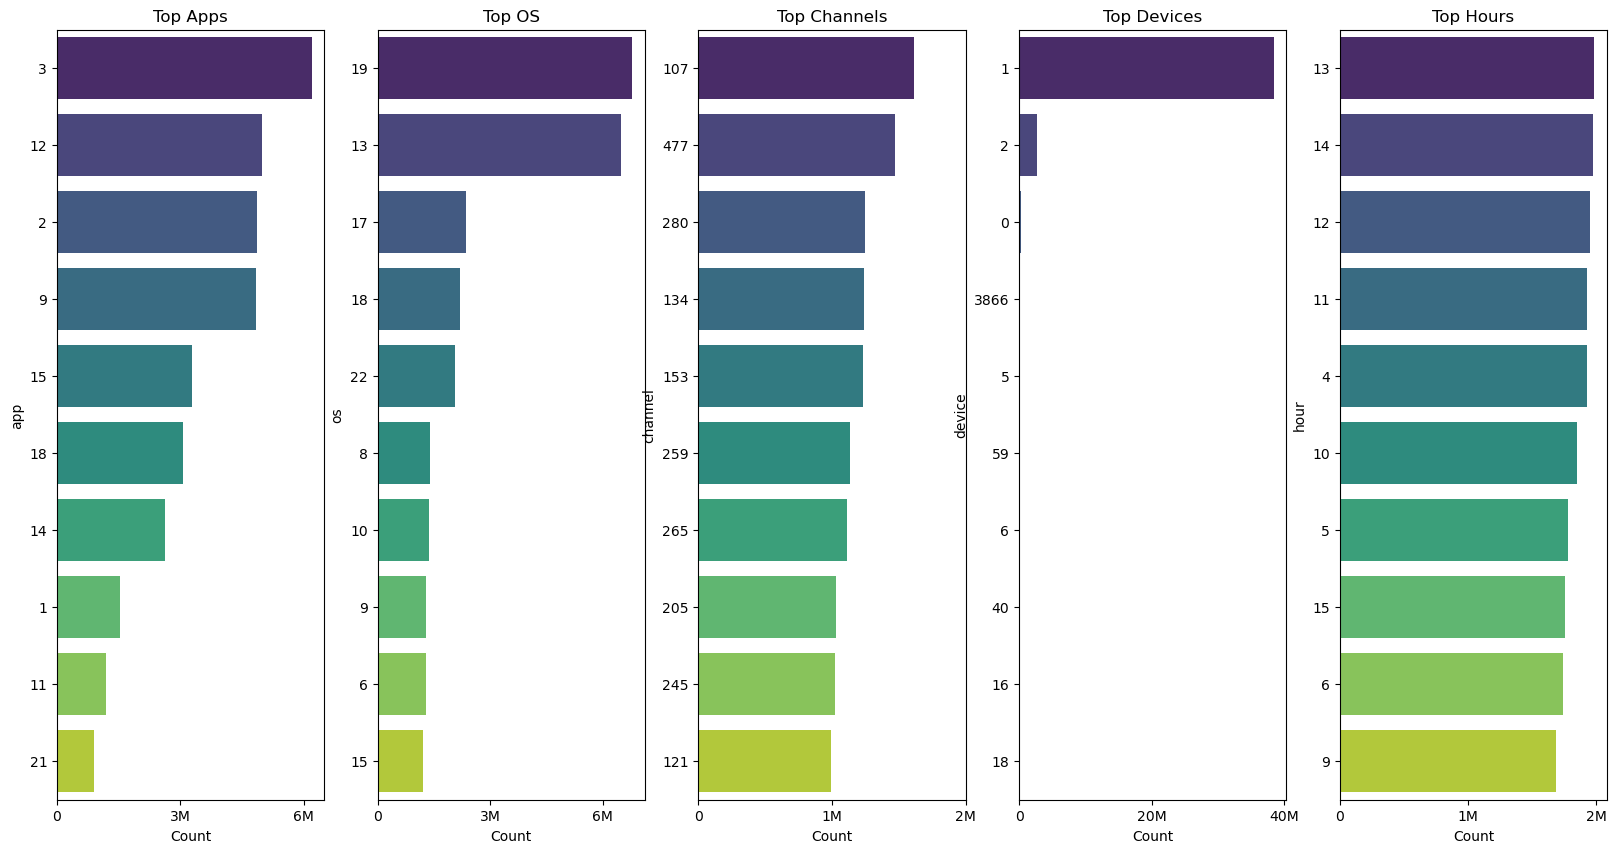

In [16]:
ten_most_apps = pd.DataFrame(df_train['app'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'app', 'app':'qtde'})
ten_most_dev = pd.DataFrame(df_train['device'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'device', 'device':'qtde'})
ten_most_os = pd.DataFrame(df_train['os'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'os', 'os':'qtde'})
ten_most_chn = pd.DataFrame(df_train['channel'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'channel', 'channel':'qtde'})
ten_most_hour = pd.DataFrame(df_train['hour'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'hour', 'hour':'qtde'})

# Graficos
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,10))

ax = axs[0]
sns.barplot(data=ten_most_apps, x='qtde', y='app', order=ten_most_apps.sort_values('qtde',ascending = False)['app'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Apps')
ax.xaxis.set_ticks(np.arange(0, 6000000+1, 3000000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[1]
sns.barplot(data=ten_most_os, x='qtde', y='os', order=ten_most_os.sort_values('qtde',ascending = False)['os'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top OS')
ax.xaxis.set_ticks(np.arange(0, 6000000+1, 3000000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[2]
sns.barplot(data=ten_most_chn, x='qtde', y='channel', order=ten_most_chn.sort_values('qtde',ascending = False)['channel'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Channels')
ax.xaxis.set_ticks(np.arange(0, 2500000+1, 1000000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[3]
sns.barplot(data=ten_most_dev, x='qtde', y='device', order=ten_most_dev.sort_values('qtde',ascending = False)['device'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Devices')
ax.xaxis.set_ticks(np.arange(0, 40000000+1, 20000000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[4]
sns.barplot(data=ten_most_hour, x='qtde', y='hour', order=ten_most_hour.sort_values('qtde',ascending = False)['hour'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Hours')
ax.xaxis.set_ticks(np.arange(0, 2500000+1, 1250000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

plt.show()

**df_train['is_attributed'] == 1**

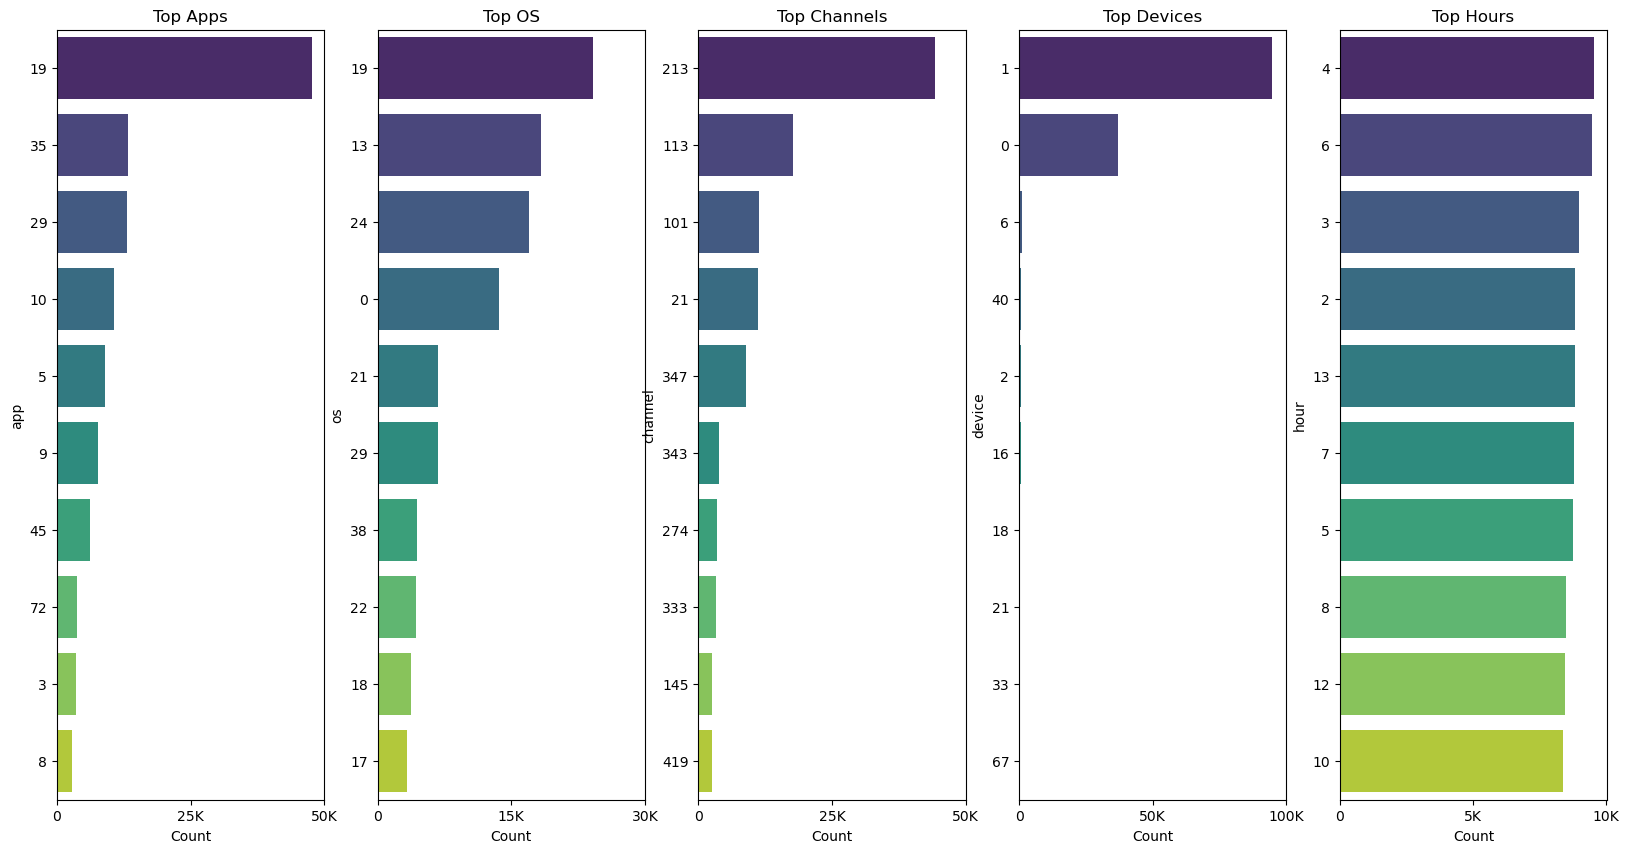

In [17]:
ten_most_apps_down = pd.DataFrame(df_train[df_train['is_attributed'] == 1]['app'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'app', 'app':'qtde'})
ten_most_os_down = pd.DataFrame(df_train[df_train['is_attributed'] == 1]['os'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'os', 'os':'qtde'})
ten_most_chn_down = pd.DataFrame(df_train[df_train['is_attributed'] == 1]['channel'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'channel', 'channel':'qtde'})
ten_most_dev_down = pd.DataFrame(df_train[df_train['is_attributed'] == 1]['device'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'device', 'device':'qtde'})
ten_most_hour_down = pd.DataFrame(df_train[df_train['is_attributed'] == 1]['hour'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'hour', 'hour':'qtde'})

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,10))

ax = axs[0]
sns.barplot(data=ten_most_apps_down, x='qtde', y='app', order=ten_most_apps_down.sort_values('qtde',ascending = False)['app'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Apps')
ax.xaxis.set_ticks(np.arange(0, 50000+1, 25000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[1]
sns.barplot(data=ten_most_os_down, x='qtde', y='os', order=ten_most_os_down.sort_values('qtde',ascending = False)['os'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top OS')
ax.xaxis.set_ticks(np.arange(0, 30000+1, 15000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[2]
sns.barplot(data=ten_most_chn_down, x='qtde', y='channel', order=ten_most_chn_down.sort_values('qtde',ascending = False)['channel'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Channels')
ax.xaxis.set_ticks(np.arange(0, 50000+1, 25000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[3]
sns.barplot(data=ten_most_dev_down, x='qtde', y='device', order=ten_most_dev_down.sort_values('qtde',ascending = False)['device'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Devices')
ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

ax = axs[4]
sns.barplot(data=ten_most_hour_down, x='qtde', y='hour', order=ten_most_hour_down.sort_values('qtde',ascending = False)['hour'], ax=ax, orient='h', palette='viridis')
ax.set_title('Top Hours')
ax.xaxis.set_ticks(np.arange(0, 10000+1, 5000))
ax.xaxis.set_major_formatter(format_number)
ax.set_xlabel('Count')

plt.show()

Analisando a Variavel Device por App

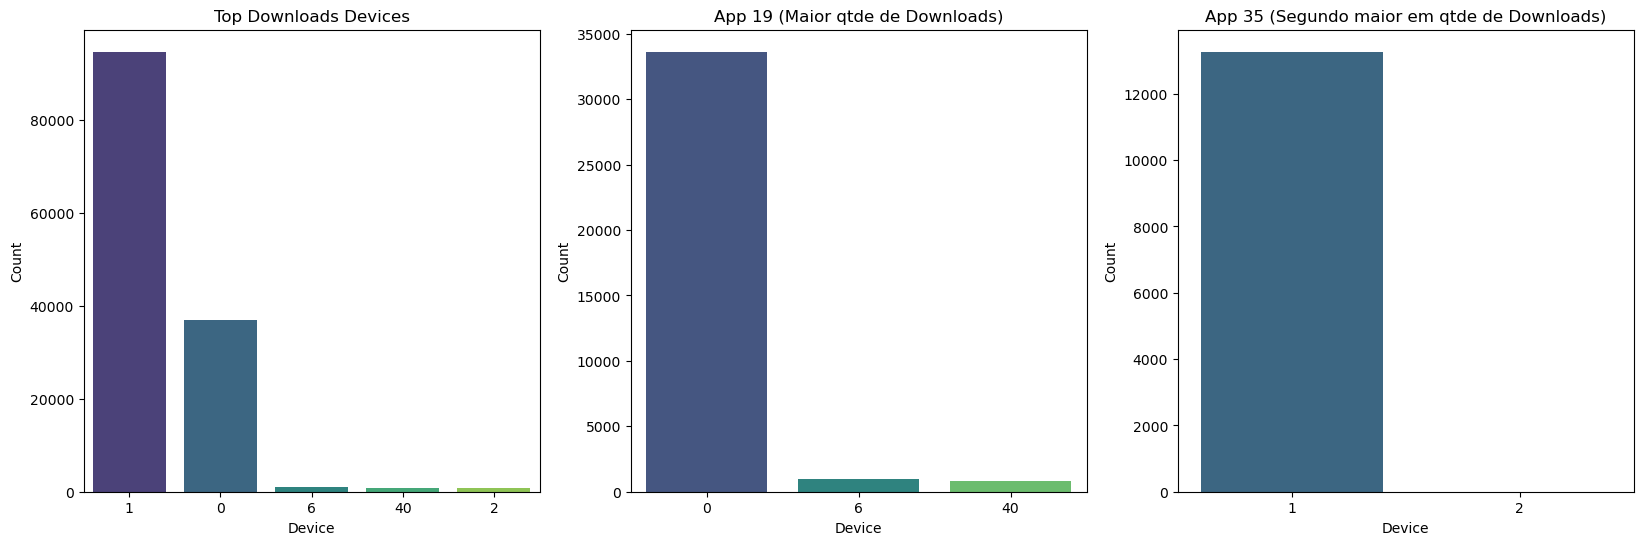

In [18]:
ten_most_dev = pd.DataFrame(df_train['device'].value_counts().iloc[:5].reset_index()).rename(columns={'index':'device', 'device':'qtde'})
ten_most_dev_down = pd.DataFrame(df_train[df_train['is_attributed'] == 1]['device'].value_counts().iloc[:5].reset_index()).rename(columns={'index':'device', 'device':'qtde'})
dev_app_down = pd.DataFrame(df_train[(df_train['app'] == 19) & (df_train['is_attributed'] == 1)]['device'].value_counts().iloc[:3].reset_index()).rename(columns={'index':'device', 'device':'qtde'})
dev_app_down2 = pd.DataFrame(df_train[(df_train['app'] == 35) & (df_train['is_attributed'] == 1)]['device'].value_counts().iloc[:10].reset_index()).rename(columns={'index':'device', 'device':'qtde'})

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

ax = axs[0]
sns.barplot(data=ten_most_dev_down, x='device', y='qtde', order=ten_most_dev_down.sort_values('qtde',ascending = False)['device'], ax=ax, palette='viridis')
ax.set_title('Top Downloads Devices')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Count')
ax.set_xlabel('Device')

ax = axs[1]
sns.barplot(data=dev_app_down, x='device', y='qtde', order=dev_app_down.sort_values('qtde',ascending = False)['device'], ax=ax, palette='viridis')
ax.set_title('App 19 (Maior qtde de Downloads)')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Count')
ax.set_xlabel('Device')

ax = axs[2]
sns.barplot(data=dev_app_down2, x='device', y='qtde', order=dev_app_down2.sort_values('qtde',ascending = False)['device'], ax=ax, palette='viridis')
ax.set_title('App 35 (Segundo maior em qtde de Downloads)')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Count')
ax.set_xlabel('Device')

plt.show()

Observação: O Device(1) com o maior número de Downloads NÃO pertence ao App com maior número de Downloads.

**Check das Datas**

**day8**

Text(0.5, 0, 'Hour')

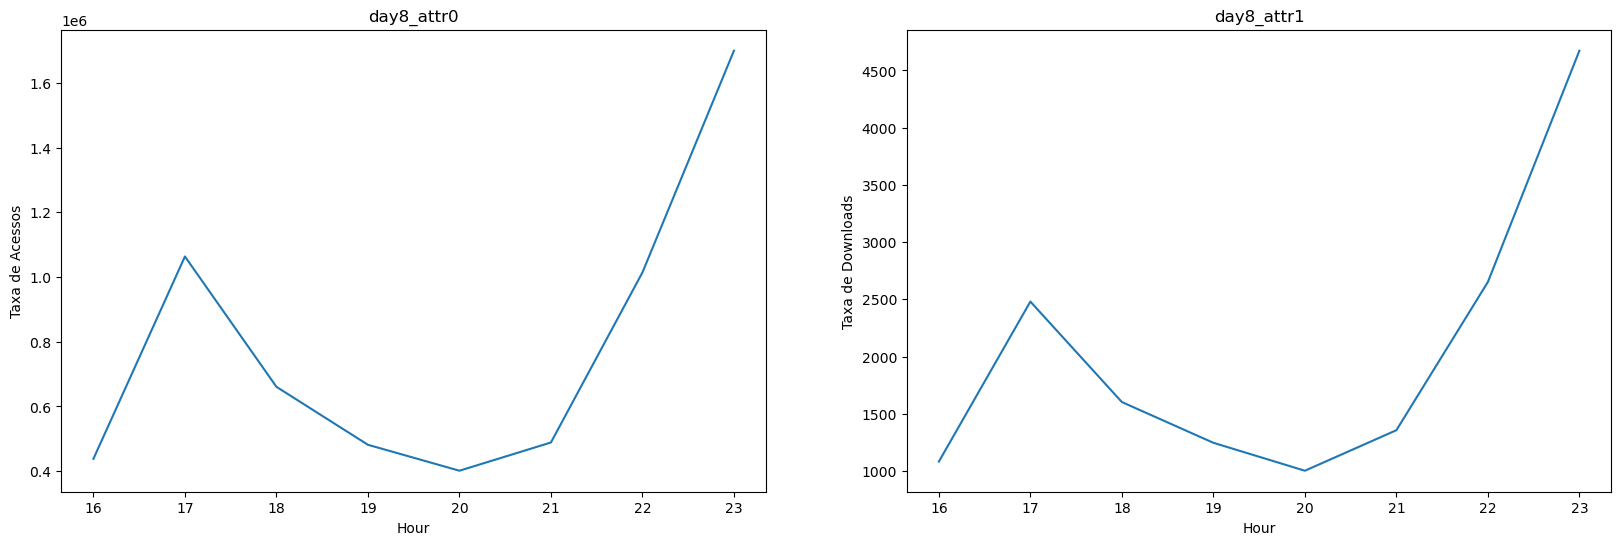

In [19]:
day8_attr0 = pd.DataFrame(df_train[(df_train['is_attributed'] == 0) & (df_train['day'] == 8)].groupby('hour')['is_attributed'].count().reset_index())
day8_attr1 = pd.DataFrame(df_train[(df_train['is_attributed'] == 1) & (df_train['day'] == 8)].groupby('hour')['is_attributed'].count().reset_index())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax = axs[0]
sns.lineplot(data=day8_attr0, x='hour', y='is_attributed', ax=ax)
ax.set_title('day8_attr0')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Taxa de Acessos')
ax.set_xlabel('Hour')

ax = axs[1]
sns.lineplot(data=day8_attr1, x='hour', y='is_attributed', ax=ax)
ax.set_title('day8_attr1')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Taxa de Downloads')
ax.set_xlabel('Hour')

**day9**

Text(0.5, 0, 'Hour')

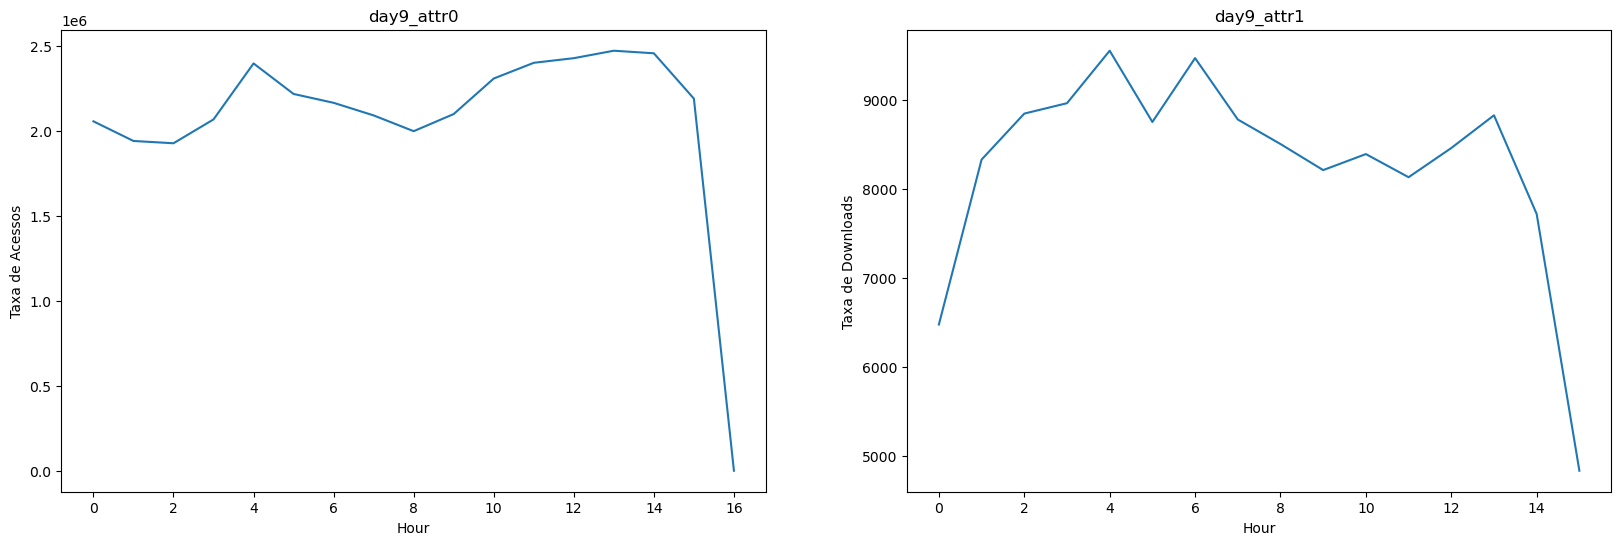

In [20]:
day9_attr0 = pd.DataFrame(df_train[(df_train['is_attributed'] == 0) & (df_train['day'] == 9)].groupby('hour')['is_attributed'].count().reset_index())
day9_attr1 = pd.DataFrame(df_train[(df_train['is_attributed'] == 1) & (df_train['day'] == 9)].groupby('hour')['is_attributed'].count().reset_index())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax = axs[0]
sns.lineplot(data=day9_attr0, x='hour', y='is_attributed', ax=ax)
ax.set_title('day9_attr0')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Taxa de Acessos')
ax.set_xlabel('Hour')

ax = axs[1]
sns.lineplot(data=day9_attr1, x='hour', y='is_attributed', ax=ax)
ax.set_title('day9_attr1')
#ax.xaxis.set_ticks(np.arange(0, 100000+1, 50000))
#ax.xaxis.set_major_formatter(format_number)
ax.set_ylabel('Taxa de Downloads')
ax.set_xlabel('Hour')

### Pré-Processamento

In [22]:
# Divisão entre as variáveis preditoras e target
X = df_train.drop('is_attributed', axis=1)
y = df_train["is_attributed"]

del df_train
gc.collect()

30431

In [23]:
# Divisão entre Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29133563, 8), (12485813, 8), (29133563,), (12485813,))

In [24]:
y_train.value_counts()

0    29029721
1      103842
Name: is_attributed, dtype: int64

In [25]:
# Aplicando o balanceamento entre as classes(0, 1)
smp = RandomUnderSampler()

X_sampler, y_sampler = smp.fit_resample(X_train, y_train)
y_sampler.value_counts()

del X_train, y_train
gc.collect()

0

### Modelagem

In [28]:
# Validação Cruzada
clf_rf = RandomForestClassifier()
scores_rf = cross_val_score(clf_rf, X_sampler, y_sampler, cv=5, scoring='roc_auc')

clf_gb = GradientBoostingClassifier()
scores_gb = cross_val_score(clf_gb, X_sampler, y_sampler, cv=5, scoring='roc_auc')

clf_xgb = XGBClassifier()
scores_xgb = cross_val_score(clf_xgb, X_sampler, y_sampler, cv=5, scoring='roc_auc')

print('RF:', scores_rf.mean(), ', SD:', scores_rf.std())
print('GB:', scores_gb.mean(), ', SD:', scores_gb.std())
print('XGB:', scores_xgb.mean(), ', SD:', scores_xgb.std())

RF:  0.9587380592468694 SD:  0.0007021939982464111
GB:  0.9518108433765418 SD:  0.0006391032007699388
XGB:  0.9662320770492846 SD:  0.000515660599021698


In [29]:
# Treino do Melhor Modelo e Predict nos dados Teste
clf_xgb.fit(X_sampler, y_sampler)
y_pred = clf_xgb.predict(X_test)

In [30]:
# Score nos dados de Teste
print(roc_auc_score(y_test, y_pred))

0.9139621641608476


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

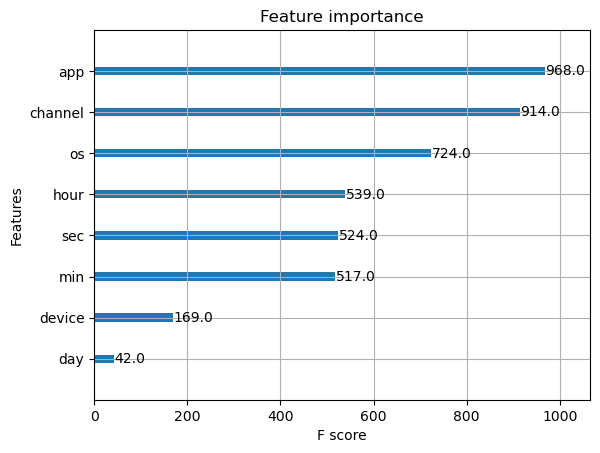

In [31]:
# Plot da importancia das variáveis para o modelo xgboost
plot_importance(clf_xgb)

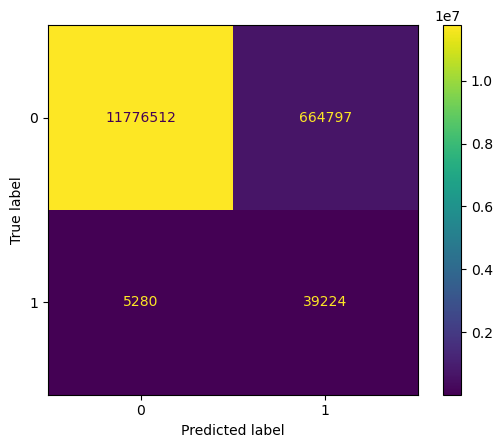

In [32]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
cm_display = ConfusionMatrixDisplay(cm).plot(values_format='')
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97  12441309
           1       0.06      0.88      0.10     44504

    accuracy                           0.95  12485813
   macro avg       0.53      0.91      0.54  12485813
weighted avg       1.00      0.95      0.97  12485813



### Preparação para os Dados de Predict

In [34]:
df_test = pd.read_csv("test.csv", usecols=cols_test, parse_dates=['click_time'], dtype=dtypes)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   click_id    uint32        
 1   ip          uint32        
 2   app         uint16        
 3   device      uint16        
 4   os          uint16        
 5   channel     uint16        
 6   click_time  datetime64[ns]
dtypes: datetime64[ns](1), uint16(4), uint32(2)
memory usage: 430.1 MB


In [39]:
df_test.head()

,app,device,os,channel,day,hour,min,sec
0,9,1,3,107,10,4,0,0
1,9,1,3,466,10,4,0,0
2,21,1,19,128,10,4,0,0
3,15,1,13,111,10,4,0,0
4,12,1,13,328,10,4,0,0


In [36]:
df_test.drop('ip', axis=1, inplace=True)

df_test['day'] = df_test['click_time'].dt.day.astype('uint16')
df_test['hour'] = df_test['click_time'].dt.hour.astype('uint8')
df_test['min'] = df_test['click_time'].dt.minute.astype('uint8')
df_test['sec'] = df_test['click_time'].dt.second.astype('uint8')
df_test.drop('click_time', axis= 1, inplace=True)

id_sub = df_test['click_id']
df_test.drop('click_id', axis=1, inplace=True)

### Predict e Submission

In [41]:
pred = clf_xgb.predict(df_test)
submit = pd.DataFrame({"click_id":id_sub, "is_attributed":pred})
submit.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [42]:
submit.to_csv('submission.csv',index=False)

Private score: 0.90118